<a href="https://colab.research.google.com/github/m-a-hasan/ai-colab/blob/main/06_transfer_learning_with_tensorflow_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Tue Nov  1 23:45:56 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Get helper function file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2022-11-01 23:45:56--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2022-11-01 23:45:57 (107 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

Time to model for 101 food classes

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2022-11-01 23:46:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 209.85.146.128, 209.85.147.128, 142.250.125.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|209.85.146.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   142MB/s    in 13s     

2022-11-01 23:46:12 (123 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/train'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/gyoza'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/tacos'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/strawberry_shortcake'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/ice_cream'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/frozen_yogurt'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/chicken_curry'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/fried_calamari'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/grilled_cheese_sandwich'.
There are 0 directories and 75 images in '101_food_classes_10_percent/train/bread_pudding'.
There are 0 directories 

In [ ]:
# Preprocessing
import tensorflow as tf
IMG_SIZE = (224, 224)

train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # Don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Model checkpoint
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy", # save the model that scores best on validation accuracy
                                                         save_best_only=True) # only keep the best model weights on the file and delete rest

In [ ]:
# Import
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

In [ ]:
# Data augmentation layer
data_augmentation = Sequential([
    preprocessing.RandomFlip("horizontal"),
    preprocessing.RandomRotation(0.2),
    preprocessing.RandomHeight(0.2),
    preprocessing.RandomWidth(0.2),
    preprocessing.RandomZoom(0.2),
    #preprocessing.Rescaling(1./255) # Don't need for EfficientNet
], name="data_augmentation")

Let's create EfficientNetB0 base model. We will make (include_top=False) so we can have our own top layer. Our top layer is GlobalAveragePooling2D followed by a Dense layer.

In [ ]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Create Model layers
inputs = layers.Input(shape=(224, 224, 3),
                      name="input_layer")

x = data_augmentation(inputs) # Augment images on input layer (only during training)
x = base_model(x, training=False) # Put base model in inference mode so we can use it to extract features without updating weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # Pool output of the base model
outputs = layers.Dense(units=len(train_data_all_10_percent.class_names),
                       activation="softmax",
                       name="output_layer")(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Fit
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15 * len(test_data)),
                                           callbacks=[checkpoint_callback])

Epoch 1/5
237/237 [==============================] - 98s 349ms/step - loss: 3.3853 - accuracy: 0.2701 - val_loss: 2.5075 - val_accuracy: 0.4563
Epoch 2/5
237/237 [==============================] - 66s 278ms/step - loss: 2.1959 - accuracy: 0.5031 - val_loss: 1.9971 - val_accuracy: 0.5241
Epoch 3/5
237/237 [==============================] - 60s 254ms/step - loss: 1.8304 - accuracy: 0.5659 - val_loss: 1.8625 - val_accuracy: 0.5310
Epoch 4/5
237/237 [==============================] - 57s 240ms/step - loss: 1.6127 - accuracy: 0.6078 - val_loss: 1.7783 - val_accuracy: 0.5448
Epoch 5/5
237/237 [==============================] - 54s 226ms/step - loss: 1.4534 - accuracy: 0.6426 - val_loss: 1.7097 - val_accuracy: 0.5636


In [ ]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 62s 79ms/step - loss: 1.5842 - accuracy: 0.5838


[1.5841988325119019, 0.5838415622711182]

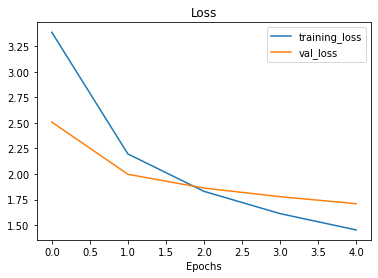

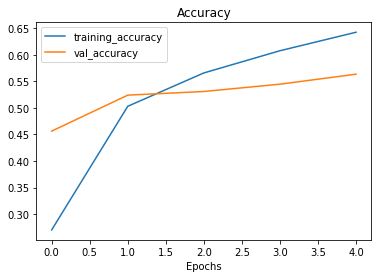

In [ ]:
# Loss curves
plot_loss_curves(history_all_classes_10_percent)

Fine-tuning time

In [ ]:
# Unfreeze
base_model.trainable = True

# Freeze everything but last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile after changing the model
model.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), # Learning rate has to be lower for fine tuning
              metrics=["accuracy"])

In [ ]:
# Which layers are trainable
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 tf.math.truediv False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze Fals

In [ ]:
# Fine-tuning for 5 more epochs
fine_tune_epochs = 10 # already have 5, we are going to have additional 5, total 10

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 64s 235ms/step - loss: 1.2074 - accuracy: 0.6849 - val_loss: 1.6875 - val_accuracy: 0.5546
Epoch 6/10
237/237 [==============================] - 60s 248ms/step - loss: 1.0904 - accuracy: 0.7053 - val_loss: 1.6533 - val_accuracy: 0.5651
Epoch 7/10
237/237 [==============================] - 53s 218ms/step - loss: 1.0099 - accuracy: 0.7282 - val_loss: 1.6610 - val_accuracy: 0.5614
Epoch 8/10
237/237 [==============================] - 48s 199ms/step - loss: 0.9421 - accuracy: 0.7476 - val_loss: 1.6365 - val_accuracy: 0.5704
Epoch 9/10
237/237 [==============================] - 45s 189ms/step - loss: 0.8832 - accuracy: 0.7648 - val_loss: 1.6727 - val_accuracy: 0.5596
Epoch 10/10
237/237 [==============================] - 44s 184ms/step - loss: 0.8331 - accuracy: 0.7776 - val_loss: 1.6330 - val_accuracy: 0.5651


In [ ]:
# Evaluate after fine tuning
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 63s 80ms/step - loss: 1.5037 - accuracy: 0.6033


[1.5036739110946655, 0.6032871007919312]

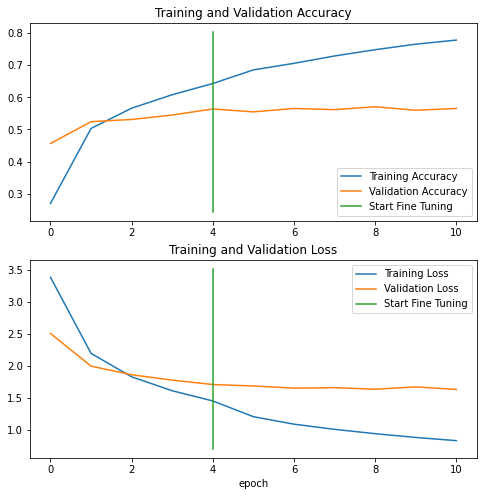

In [ ]:
# Compare fine-tune vs without fine-tune
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

In [ ]:
# Save the model in my google drive
model.save("drive/MyDrive/dev/ai/models/101_food_class_10_percent")

In [ ]:
# Load model
model = tf.keras.models.load_model("drive/MyDrive/dev/ai/models/101_food_class_10_percent")

# Checking loaded model
loaded_loss, loaded_accuracy = model.evaluate(test_data)
loaded_loss, loaded_accuracy

790/790 [==============================] - 72s 89ms/step - loss: 1.5037 - accuracy: 0.6033


(1.503674030303955, 0.6032871007919312)

In [ ]:
# Predict on all image
pred_probs = model.predict(test_data, verbose=1) # Setting verbose level to see how long it takes to predict all images

790/790 [==============================] - 72s 90ms/step


In [ ]:
# Check how many prediction it has made (we had 25250 test imagesk, in 101 classes)
pred_probs.shape

(25250, 101)

In [ ]:
# Check how the prediction tensor looks like (for first 10 predictions)
pred_probs[:10]

array([[3.8698575e-01, 4.2321169e-04, 1.4828180e-01, ..., 4.1884014e-05,
        8.7142484e-03, 2.6853351e-02],
       [9.5513296e-01, 2.3274325e-08, 3.5208653e-04, ..., 9.6392129e-03,
        1.2997505e-07, 8.6778473e-06],
       [4.8782873e-01, 4.0109903e-02, 8.9869816e-03, ..., 7.8301190e-04,
        6.3990272e-04, 1.8231199e-03],
       ...,
       [4.0031642e-01, 2.4412561e-06, 1.0119943e-03, ..., 8.0627479e-02,
        2.2123313e-04, 4.5056535e-05],
       [2.1509975e-01, 6.5072620e-04, 3.5669476e-01, ..., 5.7899806e-04,
        8.8985002e-04, 2.3347467e-04],
       [7.6937443e-01, 1.0332536e-06, 2.0881717e-03, ..., 8.7892469e-03,
        1.7949958e-06, 7.7293575e-04]], dtype=float32)

Visualizing predictions on test images
- Read image
- Turn image into tensor
- Resize image
- Rescale if necessary

In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  """
  Reads an image by the given filename, turns it into tensor and
  reshapes the image into (224, 224, 3) size.

  Parameters
  ----------
  filename (str): filename of the target image
  img_shape (int): reshaping target image to, default is 224
  scale (bool): whether to scale pixel value to a range between 0 - 1, default is True
  """

  # Read image
  img = tf.io.read_file(filename)

  # Decode the file into a tensor
  img = tf.io.decode_image(img)

  # Resize image
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    # Rescale image
    return img/225.
  else:
    return img


- Load random images from dataset
- Prediction on the random images
- Plot image, prediction, prediction probability, ground truth

In [ ]:
class_names = test_data.class_names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

1/1 [==============================] - 0s 24ms/step


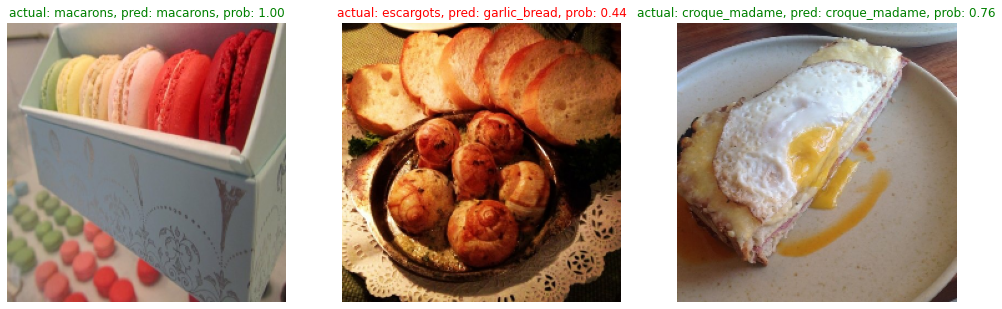

In [ ]:
import os
import random
import matplotlib.pyplot as plt

plt.figure(figsize=(17, 10))
for i in range(3):
  # Choose random image from random class
  class_name = random.choice(class_names)
  filename = random.choice(os.listdir(test_dir + class_name))
  filepath = test_dir + class_name + "/" + filename

  # Make prediction
  img = load_and_prep_image(filepath, scale=False)
  pred_prob = model.predict(tf.expand_dims(img, axis=0)) # accepts tensors of shape (224, 224, 3)
  pred_class = class_names[pred_prob.argmax()] # find predicted class

  # Plot image
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255.)
  if class_name == pred_class: # Changing color based on whether prediction is same as ground truth
    title_color = "g"
  else:
    title_color = "r"
  plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)

**Collecting all the prediction for which confidence probablity was high but was a wrong prediction (TO DO)**
- Get all image filepath
- Dataframe for filpath, ground truth, precition class, probability, ground truth classname, predicted classname
- Find all the wrong predictions on the Dataframe
- Sort based on wrong prediction with highest conviction
- Visualize